### Reading Tables

In [ ]:
import pandas as pd
import numpy as np

dpath = "deed0010.gz"

dtp = {"SALE DATE (YYYYMMDD)": str}

rdr = pd.read_csv(dpath, delimiter="|", chunksize=200000, low_memory=False, 
                  dtype=dtp)

# Loop over sub-chunks
dat = []
while True:

    try:
        df = rdr.get_chunk()
    except StopIteration:
        break

    df["SALE DATE (YYYYMMDD)"] =\
           pd.to_datetime(df["SALE DATE (YYYYMMDD)"], format="%Y%m%d", errors='coerce')

    dx = df[["APN (Parcel Number) (unformatted)", "SALE DATE (YYYYMMDD)", "SALE AMOUNT",
             "RESALE/NEW CONSTRUCTION", "RESIDENTIAL MODEL INDICATOR", "CASH/MORTGAGE PURCHASE",
             "FORECLOSURE", "FIPS", "TRANSACTION TYPE"]]
    ii = pd.notnull(dx[["APN (Parcel Number) (unformatted)", "SALE DATE (YYYYMMDD)", "CASH/MORTGAGE PURCHASE",
                        "TRANSACTION TYPE"]]).all(1)
    dx = dx.loc[ii, :]

    # Only retain records that are for "arms length sales"
    dx = dx.loc[dx["TRANSACTION TYPE"] == 1, :]

    # Convert to a number (days since 1960-01-01)
    dx["SALE DATE (YYYYMMDD)"] -= pd.to_datetime("1960-01-01")
    dx["SALE DATE (YYYYMMDD)"] = dx["SALE DATE (YYYYMMDD)"].dt.days
    dx["SALE DATE (YYYYMMDD)"] = dx["SALE DATE (YYYYMMDD)"].astype(np.float64)

    Drop non-residential properties
    dx = dx.loc[dx["RESIDENTIAL MODEL INDICATOR"] == "Y"]

    # Drop properties with only one record
    gb = dx.groupby("APN (Parcel Number) (unformatted)")
    nr = pd.DataFrame(gb.size())
    nr.columns = ["numrecs"]
    dx = pd.merge(dx, nr, left_on="APN (Parcel Number) (unformatted)", right_index=True)
    dx = dx.loc[dx.numrecs > 1]
    
    #dx = dx.loc[:, ["APN (Parcel Number) (unformatted)", "SALE DATE (YYYYMMDD)", "SALE AMOUNT", 
    #                "FIPS", "RESALE/NEW CONSTRUCTION"]]

    dat.append(dx)

deed = pd.concat(dat, axis=0)

In [146]:
deed.head()

,APN (Parcel Number) (unformatted),SALE DATE,SALE AMOUNT,FIPS,CASH/MORTGAGE PURCHASE,MORTGAGE AMOUNT
68,&A388500002,19039.0,257300.0,55127,Q,NaN
69,&A388500002,19058.0,257300.0,55127,Q,NaN
75,&LA1 00010,19530.0,265000.0,55127,Q,NaN
76,&LA1 00010,20011.0,265000.0,55127,Q,NaN
78,&LA1 00010,20709.0,321400.0,55127,Q,NaN


In [241]:
popu = pd.read_csv('county_population.csv')

In [254]:
popu.head()

,f,FIPS,pop1970,pop1971,pop1972,pop1973,pop1974,pop1975,pop1976,pop1977,...,pop2005,pop2006,pop2007,pop2008,pop2009,pop2010,pop2011,pop2012,pop2013,pop2014
0,0,0,203302037.0,206826000.0,209283000.0,211356000.0,213341000.0,215464000.0,217562000.0,219759000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1000,0,3444354.0,3497000.0,3540000.0,3581000.0,3628000.0,3680000.0,3737000.0,3783000.0,...,4545049.0,4597688.0,4637904.0,4677464.0,4708708.0,NaN,NaN,NaN,NaN,NaN
2,1001,1,24460.0,25500.0,27200.0,28500.0,29300.0,29700.0,29900.0,30500.0,...,47870.0,49105.0,49834.0,50354.0,50756.0,NaN,NaN,NaN,NaN,NaN
3,1001,1001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,54684.0,55275.0,55192.0,55136.0,55395.0
4,1003,3,59382.0,60100.0,62400.0,64200.0,66100.0,67900.0,70200.0,72400.0,...,162564.0,168516.0,172815.0,176212.0,179878.0,NaN,NaN,NaN,NaN,NaN


In [243]:
nam=['fips',"county_fips"]
for i in range(1970,2015):
    nam.append('pop'+str(i))

In [244]:
popu = popu[nam]

In [252]:
nam[0] = 'f';nam[1] = 'FIPS'

In [253]:
popu.columns=nam

In [180]:
dx.head()

,apn,SaleDate,SaleAmount,FIPS,popu,year_built,living_feet,total_rooms,condition,construction,...,logpop,logliving_feet,SaleYear,condition2,quality2,age,tdiff,status,numrecs_x,numrecs_y
38291,0,7993.0,143000.0,12057,1316298.0,1988.0,2168.0,NaN,AVE,FRY,...,20.328055,11.082149,2001,0,1,13.0,1283.0,1,2,2
38292,0,9276.0,282000.0,12057,1316298.0,1988.0,2168.0,NaN,AVE,FRY,...,20.328055,11.082149,2005,0,1,17.0,11725.0,0,2,2
52829,1,5646.0,39000.0,42003,1231255.0,1905.0,2001.0,5.0,GOO,LOG,...,20.231698,10.966505,1995,1,0,90.0,2249.0,1,5,5
52830,1,7895.0,74100.0,42003,1231255.0,1905.0,2001.0,5.0,GOO,LOG,...,20.231698,10.966505,2001,1,0,96.0,2329.0,1,5,5
52831,1,10224.0,164000.0,42003,1231255.0,1905.0,2001.0,5.0,GOO,LOG,...,20.231698,10.966505,2008,1,0,103.0,219.0,1,5,5


In [210]:
temp=pd.merge(dx,popu,on='FIPS')

In [231]:
temp.SaleYear.value_counts()

2005    2176
2004    2109
2003    1912
2006    1712
2002    1679
2008    1615
2001    1574
2010    1564
2009    1560
2000    1544
2011    1529
2015    1528
2016    1517
2013    1501
2012    1494
2014    1434
2007    1423
1999    1254
1998    1000
2017     593
1997     579
1994     450
1996     449
1995     441
1989     388
1990     387
1993     379
1988     365
1987     328
1992     319
1991     319
1986     287
1985      95
1980      61
1979      59
1984      57
1983      53
1981      53
1982      38
1976       2
1978       2
1977       1
Name: SaleYear, dtype: int64

In [225]:
temp.shape

(35830, 67)

In [211]:
temp.head()

,apn,SaleDate,SaleAmount,FIPS,popu,year_built,living_feet,total_rooms,condition,construction,...,pop2005,pop2006,pop2007,pop2008,pop2009,pop2010,pop2011,pop2012,pop2013,pop2014
0,0,7993.0,143000.0,12057,1316298.0,1988.0,2168.0,NaN,AVE,FRY,...,NaN,NaN,NaN,NaN,NaN,1234145.0,1271720.0,1282032.0,1294145.0,1316298.0
1,0,9276.0,282000.0,12057,1316298.0,1988.0,2168.0,NaN,AVE,FRY,...,NaN,NaN,NaN,NaN,NaN,1234145.0,1271720.0,1282032.0,1294145.0,1316298.0
2,3,8247.0,156000.0,12057,1316298.0,1998.0,1792.0,NaN,AVE,FRY,...,NaN,NaN,NaN,NaN,NaN,1234145.0,1271720.0,1282032.0,1294145.0,1316298.0
3,3,8756.0,170000.0,12057,1316298.0,1998.0,1792.0,NaN,AVE,FRY,...,NaN,NaN,NaN,NaN,NaN,1234145.0,1271720.0,1282032.0,1294145.0,1316298.0
4,4,6822.0,142000.0,12057,1316298.0,1996.0,2055.0,NaN,AVE,FRY,...,NaN,NaN,NaN,NaN,NaN,1234145.0,1271720.0,1282032.0,1294145.0,1316298.0


In [3]:
deed_n.columns = ['UNFORMATTED APN', 'SaleDate','SaleAmount','FIPS','Resale/New','Popu']

In [4]:
deed_n.head()

,UNFORMATTED APN,SaleDate,SaleAmount,FIPS,Resale/New,Popu
0,&A 3100001,20919.0,450000.0,55127,M,103527.0
1,&A388500002,19039.0,257300.0,55127,M,103527.0
2,&A388500002,19058.0,257300.0,55127,M,103527.0
3,&B 400003D2,18606.0,500000.0,55127,M,103527.0
4,&B 700007,20265.0,80000.0,55127,M,103527.0


In [171]:
dpath = "tax0010.gz"

dtp = {"CENSUS TRACT": str} #"SALE DATE (YYYYMMDD)": str}

rdr = pd.read_csv(dpath, delimiter="|", chunksize=200000, low_memory=False, 
                  dtype=dtp, error_bad_lines=False)

n = 0
# Loop over sub-chunks
dat = []
while True:

    try:
        df = rdr.get_chunk()
    except StopIteration:
        break
    
    n += df.shape[0]

    # Keep only single family residences
    df = df.loc[df["PROPERTY INDICATOR"] == 10, :]

    dx = df[['FIPS CODE', 'UNFORMATTED APN', 'YEAR BUILT', \
             'BUILDING SQUARE FEET', 'LIVING SQUARE FEET', 'TOTAL ROOMS', \
             'CONDITION', \
             'CONSTRUCTION TYPE','EXTERIOR WALLS','FLOOR','FRAME','PARKING SPACES','STORIES CODE','POOL','QUALITY']]
    ii = pd.notnull(dx[["UNFORMATTED APN"]]).all(1)
    dx = dx.loc[ii, :]
    
    dat.append(dx)

tax = pd.concat(dat, axis=0)

# Keep only one record per house
tax = tax.groupby("UNFORMATTED APN").head(1)

# We need to know the year in which the house was built
tax = tax.loc[pd.notnull(tax["YEAR BUILT"]), :]



Skipping line 66407: expected 179 fields, saw 180
Skipping line 139634: expected 179 fields, saw 180
Skipping line 179350: expected 179 fields, saw 181
Skipping line 183451: expected 179 fields, saw 180

Skipping line 201002: expected 179 fields, saw 181
Skipping line 220708: expected 179 fields, saw 180

Skipping line 472089: expected 179 fields, saw 180
Skipping line 534273: expected 179 fields, saw 181

Skipping line 769660: expected 179 fields, saw 180
Skipping line 770426: expected 179 fields, saw 180
Skipping line 770468: expected 179 fields, saw 180
Skipping line 770692: expected 179 fields, saw 180
Skipping line 796714: expected 179 fields, saw 180

Skipping line 821943: expected 179 fields, saw 180
Skipping line 840992: expected 179 fields, saw 180
Skipping line 841199: expected 179 fields, saw 180
Skipping line 851094: expected 179 fields, saw 180
Skipping line 866985: expected 179 fields, saw 180
Skipping line 890553: expected 179 fields, saw 180
Skipping line 895255: expect

In [172]:
tax.head()

,FIPS CODE,UNFORMATTED APN,YEAR BUILT,BUILDING SQUARE FEET,LIVING SQUARE FEET,TOTAL ROOMS,CONDITION,CONSTRUCTION TYPE,EXTERIOR WALLS,FLOOR,FRAME,PARKING SPACES,STORIES CODE,POOL,QUALITY
76,28017,0-014 -20-015.00,1939.0,2019.0,1443.0,7.0,GOO,NaN,SDS,NaN,NaN,NaN,010,NaN,QFA
80,28017,0-023 -05-011.00,1964.0,1586.0,1456.0,5.0,GOO,NaN,SDS,NaN,NaN,NaN,010,NaN,QAV
89,28017,0-038 -27-007.00,1984.0,1769.0,1620.0,5.0,GOO,NaN,BRV,NaN,NaN,NaN,NaN,NaN,QVV
94,28017,0-049 -31-005.00,1955.0,1468.0,1228.0,5.0,GOO,NaN,HAR,NaN,NaN,NaN,010,NaN,QAV
96,28017,0-052 -10-011.00,1958.0,985.0,851.0,5.0,GOO,NaN,VIN,NaN,NaN,NaN,010,NaN,QBA


In [173]:
data_new = pd.merge(deed_n,tax,on='UNFORMATTED APN')
data_new.to_csv("data_new2.csv", compression="gzip")

In [174]:
data_new.head()

,UNFORMATTED APN,SaleDate,SaleAmount,FIPS,Resale/New,Popu,FIPS CODE,YEAR BUILT,BUILDING SQUARE FEET,LIVING SQUARE FEET,TOTAL ROOMS,CONDITION,CONSTRUCTION TYPE,EXTERIOR WALLS,FLOOR,FRAME,PARKING SPACES,STORIES CODE,POOL,QUALITY
0,000000000000020065,14875.0,8000.0,12133,M,24451.0,12133,2013.0,1792.0,1792.0,NaN,NaN,NaN,VIN,NaN,NaN,NaN,NaN,NaN,QAV
1,000000000000040120,14972.0,13000.0,12133,M,24451.0,12133,2006.0,2098.0,1698.0,NaN,NaN,NaN,VIN,NaN,NaN,NaN,NaN,NaN,QAV
2,000000000001470058,18260.0,15000.0,12133,M,24451.0,12133,2012.0,552.0,384.0,NaN,NaN,NaN,VIN,G00,NaN,NaN,NaN,NaN,QAV
3,000000000007280004,18732.0,21000.0,12133,M,24451.0,12133,1975.0,1521.0,1248.0,NaN,NaN,NaN,CBS,NaN,NaN,NaN,NaN,NaN,QAV
4,000000000007280004,19191.0,89000.0,12133,M,24451.0,12133,1975.0,1521.0,1248.0,NaN,NaN,NaN,CBS,NaN,NaN,NaN,NaN,NaN,QAV


### Feature Selection

In [40]:
data_new.shape

(536717, 16)

In [398]:
data_new.columns = ['apn','SaleDate','SaleAmount','FIPS', 'resale','popu','FIPS2','year_built','building_feet','living_feet' ,'total_rooms','condition','construction','wall','floor','frame','parking','stories','pool','quality']
data_new = data_new[['apn','SaleDate','SaleAmount','FIPS','popu','year_built','living_feet' ,'total_rooms','condition','construction','pool','quality']]

In [399]:
data_new.head()

,apn,SaleDate,SaleAmount,FIPS,popu,year_built,living_feet,total_rooms,condition,construction,pool,quality
0,000000000000020065,14875.0,8000.0,12133,24451.0,2013.0,1792.0,NaN,NaN,NaN,N,QAV
1,000000000000040120,14972.0,13000.0,12133,24451.0,2006.0,1698.0,NaN,NaN,NaN,N,QAV
2,000000000001470058,18260.0,15000.0,12133,24451.0,2012.0,384.0,NaN,NaN,NaN,N,QAV
3,000000000007280004,18732.0,21000.0,12133,24451.0,1975.0,1248.0,NaN,NaN,NaN,N,QAV
4,000000000007280004,19191.0,89000.0,12133,24451.0,1975.0,1248.0,NaN,NaN,NaN,N,QAV


In [410]:
data_new['logSaleAmount'] = np.log2(data_new.SaleAmount)
data_new['logpop'] = np.log2(data_new.popu)
data_new.pool=data_new.pool.fillna('N')
data_new.pool=data_new.pool.replace(r' ', 'N')
dr = data_new
dr = dr.loc[pd.notnull(dr.SaleAmount)]
dr = dr.loc[pd.notnull(dr.year_built)]
dr = dr.loc[pd.notnull(dr.living_feet)]
dr = dr.loc[pd.notnull(dr.condition)]
dr = dr.loc[pd.notnull(dr.quality)]
dr = dr.loc[pd.notnull(dr.construction)]
dr = dr.loc[dr.construction != '001']
dr = dr.loc[dr.SaleAmount>1]
dr['logliving_feet'] = np.log2(dr.living_feet)
dr['SaleYear'] = (dr.SaleDate/365 + 1960).astype(int)
dr = dr.loc[dr.SaleYear>1979]
dr['pool']=dr['pool'].replace(['N','Y'], [0,1])
dr.SaleDate = dr.SaleDate - 6936
dr['condition2'] = dr.condition.replace(['AVE', 'GOO', 'POO', 'VGO', 'EXC', 'FAI', 'UNS', 'DMG', 'UCN', 'GTE','001'],
                                     [0,1,-3,2,4,-1,-3,-2,0,3,0])
dr['quality2'] = dr.quality.replace(['QAV', 'QGO', 'QFA', 'QVV', '001','QEX','QBA','QLO','QPO','QEC','QLU','000'],
                                     [0,2,-3,1,0,3,-2,-4,-5,-1,4,0])
dr['condition'] = dr.condition.replace(['AVE', 'GOO', 'POO', 'VGO', 'EXC', 'FAI', 'UNS', 'DMG', 'UCN', 'GTE','001'],
                                     ['AVE', 'GOO', 'POO', 'VGO', 'EXC', 'FAI', 'UNS', 'DMG', 'AVE', 'GTE','AVE'])
dr['quality'] = dr.quality.replace(['QAV', 'QGO', 'QFA', 'QVV', '001','QEX','QBA','QLO','QPO','QEC','QLU','000'],
                                     ['QAV', 'QGO', 'QFA', 'QVV', 'QAV','QEX','QBA','QLO','QPO','QEC','QLU','AVE'])
dr['age'] = dr.SaleYear - dr.year_built
dr.SaleDate = dr.SaleDate-364
dr.logSaleAmount = (np.log2(dr.SaleAmount))
dr.shape

(42906, 18)

In [510]:
dr.head()

,apn,SaleDate,SaleAmount,FIPS,popu,year_built,living_feet,total_rooms,condition,construction,pool,quality,logSaleAmount,logpop,logliving_feet,SaleYear,condition2,quality2,age
14543,0005226,12943.0,28000.00,37081,512119.0,1965.0,1279.0,5.0,AVE,MAS,0,QAV,14.773139,13.146312,10.320801,2015,0,0,50.0
14544,0005226,13263.0,75000.00,40083,45276.0,1965.0,1279.0,5.0,AVE,MAS,0,QAV,16.194603,10.720532,10.320801,2016,0,0,51.0
14547,0005226,12496.0,91732.24,48077,10370.0,1965.0,1279.0,5.0,AVE,MAS,0,QAV,16.485141,9.246672,10.320801,2014,0,0,49.0
14563,0006980,9062.0,95000.00,37081,512119.0,1941.0,1257.0,7.0,AVE,FRM,0,QGO,16.535640,13.146312,10.295769,2004,0,2,63.0
14564,0006980,9127.0,105000.00,37081,512119.0,1941.0,1257.0,7.0,AVE,FRM,0,QGO,16.680030,13.146312,10.295769,2005,0,2,64.0


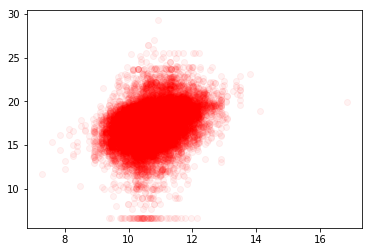

In [412]:
plt.plot(dr.logliving_feet,dr.logSaleAmount,'ro',alpha=0.05)


In [ ]:
import statsmodels.api as sm
import matplotlib
matplotlib.use('Agg')
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.pyplot as plt

(array([  8.40000000e+01,   1.03000000e+02,   5.17000000e+02,
         3.54900000e+03,   2.51160000e+04,   1.23860000e+04,
         9.55000000e+02,   1.74000000e+02,   2.10000000e+01,
         1.00000000e+00]), array([  6.64385619,   8.90937382,  11.17489144,  13.44040907,
        15.7059267 ,  17.97144433,  20.23696196,  22.50247958,
        24.76799721,  27.03351484,  29.29903247]), <a list of 10 Patch objects>)


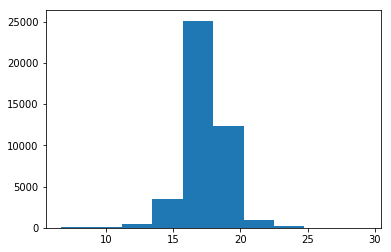

In [587]:
%matplotlib inline
print plt.hist(dr.logSaleAmount)

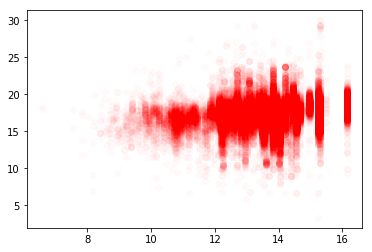

In [392]:
plt.plot(dr.logpop,dr.logSaleAmount, 'ro',alpha=0.02)

In [627]:
dr.logliving_feet = np.log2(dr.living_feet)

In [764]:
model = sm.MixedLM.from_formula('logSaleAmount ~ bs(SaleDate,8) + logliving_feet + construction + condition + age +\
 bs(SaleDate,8) * logliving_feet + \
 bs(SaleDate,8) * age',groups = 'FIPS', data=dr)
result = model.fit()
print result.summary()

                    Mixed Linear Model Regression Results
Model:                  MixedLM       Dependent Variable:       logSaleAmount
No. Observations:       42906         Method:                   REML         
No. Groups:             249           Scale:                    1.4341       
Min. group size:        1             Likelihood:               -69065.8817  
Max. group size:        7848          Converged:                Yes          
Mean group size:        172.3                                                
-----------------------------------------------------------------------------
                                  Coef.  Std.Err.   z    P>|z|  [0.025 0.975]
-----------------------------------------------------------------------------
Intercept                         11.240    2.052  5.478 0.000   7.219 15.262
construction[T.ALV]                1.376    0.358  3.843 0.000   0.674  2.078
construction[T.BRC]                2.245    1.224  1.835 0.067  -0.153  4.643
constr

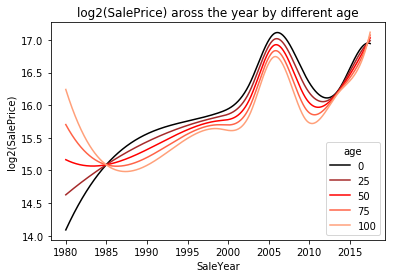

In [765]:
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
n=13691
k=25
fig, ax = plt.subplots()
co = ['black','brown','red','tomato','lightsalmon']
for i in range(5):
    dx = pd.DataFrame({'SaleDate': np.linspace(0,n,num=n),'logliving_feet':[10]*n,
                   'construction': ['WOO']*n,'condition': ['AVE']*n, 'age': [i*k]*n}) # 
    trend = result.predict(exog = dx)
    ax.plot(dx.SaleDate/365+1980, trend,color = co[i])
plt.xlabel('SaleYear')
plt.ylabel('log2(SalePrice)')
plt.title('log2(SalePrice) aross the year by different age')
import matplotlib.lines as mlines
# Create custom legend
ra = [0*k,1*k,2*k,3*k,4*k]
l1 = mlines.Line2D([], [], color=co[0],markersize=15, label=ra[0])
l2 = mlines.Line2D([], [], color=co[1], markersize=15, label=ra[1])
l3 = mlines.Line2D([], [], color=co[2],markersize=15, label=ra[2])
l4 = mlines.Line2D([], [], color=co[3], markersize=15, label=ra[3])
l5 = mlines.Line2D([], [], color=co[4],markersize=15, label=ra[4])
ax.legend(handles=[l1,l2,l3,l4,l5], loc='best',title='age')

(array([  1.63000000e+02,   1.39360000e+04,   1.46910000e+04,
          9.83000000e+03,   2.82600000e+03,   1.25700000e+03,
          1.77000000e+02,   1.00000000e+01,   6.00000000e+00,
          1.00000000e+01]),
 array([ -34. ,   -9.9,   14.2,   38.3,   62.4,   86.5,  110.6,  134.7,
         158.8,  182.9,  207. ]),
 <a list of 10 Patch objects>)

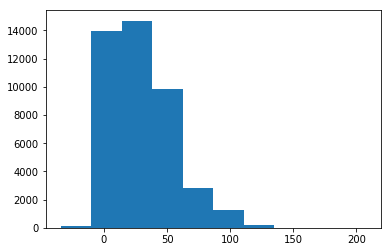

In [766]:
plt.hist(dr.age)

older house are cheaper.

(array([  1.00000000e+01,   6.00000000e+00,   5.00000000e+00,
          4.80000000e+01,   5.16000000e+02,   2.13100000e+03,
          3.37400000e+03,   1.10690000e+04,   1.55470000e+04,
          1.02000000e+04]),
 array([ 1801. ,  1822.5,  1844. ,  1865.5,  1887. ,  1908.5,  1930. ,
         1951.5,  1973. ,  1994.5,  2016. ]),
 <a list of 10 Patch objects>)

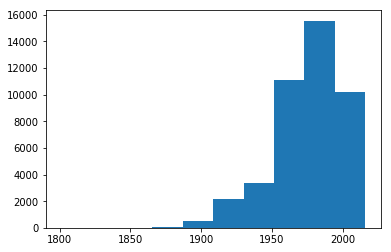

In [767]:
plt.hist(dr.year_built)

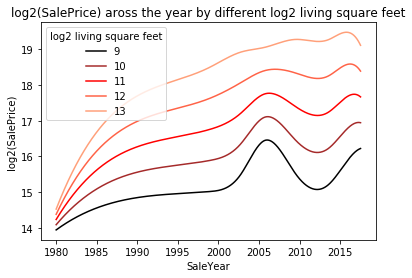

In [781]:
n=13691
k=9
fig, ax = plt.subplots()
co = ['black','brown','red','tomato','lightsalmon']
for i in range(5):
    dx = pd.DataFrame({'SaleDate': np.linspace(0,n,num=n),'logliving_feet':[i+9]*n,
                   'construction': ['WOO']*n,'condition': ['AVE']*n, 'age': [0]*n}) # 
    trend = result.predict(exog = dx)
    ax.plot(dx.SaleDate/365+1980, trend,color = co[i])
plt.xlabel('SaleYear')
plt.ylabel('log2(SalePrice)')
plt.title('log2(SalePrice) aross the year by different log2 living square feet')
import matplotlib.lines as mlines
# Create custom legend
ra = [0+k,1+k,2+k,3+k,4+k]
l1 = mlines.Line2D([], [], color=co[0],markersize=15, label=ra[0])
l2 = mlines.Line2D([], [], color=co[1], markersize=15, label=ra[1])
l3 = mlines.Line2D([], [], color=co[2],markersize=15, label=ra[2])
l4 = mlines.Line2D([], [], color=co[3], markersize=15, label=ra[3])
l5 = mlines.Line2D([], [], color=co[4],markersize=15, label=ra[4])
ax.legend(handles=[l1,l2,l3,l4,l5], loc='best',title = 'log2 living square feet')

large house is more expensive.

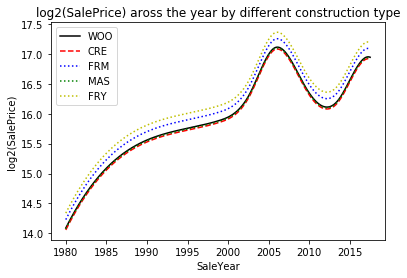

In [782]:
n=13691
k=9
fig, ax = plt.subplots()
cons = ['WOO','CRE','FRM','MAS','FRY','WMT']
li = ['-', '--', ':', ':', ':']
co = ['k','r','b','g','y']
for i in range(5):
    dx = pd.DataFrame({'SaleDate': np.linspace(0,n,num=n),'logliving_feet':[10]*n,
                   'construction': [cons[i]]*n,'condition': ['AVE']*n, 'age': [0]*n}) # 
    trend = result.predict(exog = dx)
    ax.plot(dx.SaleDate/365+1980, trend,color = co[i], linestyle=li[i])
plt.xlabel('SaleYear')
plt.ylabel('log2(SalePrice)')
plt.title('log2(SalePrice) aross the year by different construction type')
import matplotlib.lines as mlines
# Create custom legend
ra = cons
l1 = mlines.Line2D([], [], color = co[0], linestyle=li[0],markersize=15, label=ra[0])
l2 = mlines.Line2D([], [], color = co[1], linestyle=li[1], markersize=15, label=ra[1])
l3 = mlines.Line2D([], [], color = co[2], linestyle=li[2],markersize=15, label=ra[2])
l4 = mlines.Line2D([], [], color = co[3], linestyle=li[3], markersize=15, label=ra[3])
l5 = mlines.Line2D([], [], color = co[4], linestyle=li[4],markersize=15, label=ra[4])
ax.legend(handles=[l1,l2,l3,l4,l5], loc='best')

In [783]:
(2**16.5-2**17)/2**17


-0.2928932188134524

In [784]:
(2**17.2-2**17.0)/2**17

0.14869835499703443

CRE < MAS < WOO < FRM < FRY
CRE	CONCRETE
FRM	FRAME
FRY	FRAME/MASONRY
MAS	MASONRY
WOO	WOOD

In [792]:
temp = ((dr.SaleYear-1980)/5).astype(int)
temp.value_counts()
dr.five = temp

In [800]:
dr2 = dr.loc[dr.five==7]
model = sm.MixedLM.from_formula('logSaleAmount ~ bs(SaleDate,8) + logliving_feet + construction + condition + age +\
 bs(SaleDate,8) * logliving_feet + \
 bs(SaleDate,8) * age',groups = 'FIPS', data=dr2)
result = model.fit()
print result.summary()

                    Mixed Linear Model Regression Results
Model:                   MixedLM      Dependent Variable:      logSaleAmount
No. Observations:        4497         Method:                  REML         
No. Groups:              175          Scale:                   1.2938       
Min. group size:         1            Likelihood:              -7211.1502   
Max. group size:         741          Converged:               Yes          
Mean group size:         25.7                                               
----------------------------------------------------------------------------
                                  Coef.  Std.Err.   z    P>|z| [0.025 0.975]
----------------------------------------------------------------------------
Intercept                         -1.212    3.849 -0.315 0.753 -8.757  6.332
construction[T.ALV]               -0.271    1.036 -0.261 0.794 -2.301  1.759
construction[T.BRF]                0.266    0.922  0.288 0.773 -1.541  2.073
construction[T.BRK

In [806]:
a = [0.118,0.440,0.552,0.706,1.206,1.867,1.3805,2.401]
b = [1.03,1.1161,0.9561,1.0905,1.3246,1.3409,1.7661,1.2938]
c = [a[i]/(a[i]+b[i]) for i in range(8)]
year = [1980,1985,1990,1995,2000,2005,2010,2015]

Text(0,0.5,u'ICC')

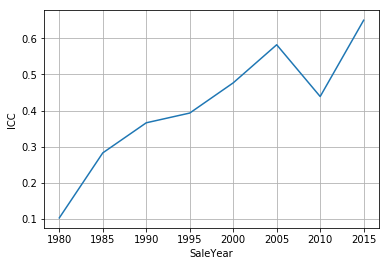

In [809]:
plt.plot(year,c)
plt.grid()
plt.xlabel('SaleYear')
plt.ylabel('ICC')

# Variable effects

In [743]:
model = sm.MixedLM.from_formula('logSaleAmount ~ bs(SaleDate,8) + logliving_feet + construction + condition + age +\
 bs(SaleDate,8) * logliving_feet + \
 bs(SaleDate,8) * age',groups = 'FIPS', data=dr)
result = model.fit()
print result.summary()
sst_val = sum(map(lambda x: np.power(x,2),dr.logSaleAmount-np.mean(dr.logSaleAmount))) 
sse_val = sum(map(lambda x: np.power(x,2),dr.logSaleAmount-result.fittedvalues)) 
r2 = []
r2.append(1.0 - sse_val/sst_val) 

                    Mixed Linear Model Regression Results
Model:                  MixedLM       Dependent Variable:       logSaleAmount
No. Observations:       42906         Method:                   REML         
No. Groups:             249           Scale:                    1.4341       
Min. group size:        1             Likelihood:               -69065.8817  
Max. group size:        7848          Converged:                Yes          
Mean group size:        172.3                                                
-----------------------------------------------------------------------------
                                  Coef.  Std.Err.   z    P>|z|  [0.025 0.975]
-----------------------------------------------------------------------------
Intercept                         11.240    2.052  5.478 0.000   7.219 15.262
construction[T.ALV]                1.376    0.358  3.843 0.000   0.674  2.078
construction[T.BRC]                2.245    1.224  1.835 0.067  -0.153  4.643
constr

## No log living feet

## No age

In [744]:
model = sm.MixedLM.from_formula('logSaleAmount ~ bs(SaleDate,8) + logliving_feet + construction + condition+\
 bs(SaleDate,8) * logliving_feet',groups = 'FIPS', data=dr)
result = model.fit()
result.summary()
sst_val = sum(map(lambda x: np.power(x,2),dr.logSaleAmount-np.mean(dr.logSaleAmount))) 
sse_val = sum(map(lambda x: np.power(x,2),dr.logSaleAmount-result.fittedvalues)) 
r2.append(1.0 - sse_val/sst_val) 

## No construction

In [745]:
model = sm.MixedLM.from_formula('logSaleAmount ~ bs(SaleDate,8) + logliving_feet + condition + age +\
 bs(SaleDate,8) * logliving_feet + \
 bs(SaleDate,8) * age',groups = 'FIPS', data=dr)
result = model.fit()
result.summary()
sst_val = sum(map(lambda x: np.power(x,2),dr.logSaleAmount-np.mean(dr.logSaleAmount))) 
sse_val = sum(map(lambda x: np.power(x,2),dr.logSaleAmount-result.fittedvalues)) 
r2.append(1.0 - sse_val/sst_val) 

## no condition

In [746]:
model = sm.MixedLM.from_formula('logSaleAmount ~ bs(SaleDate,8) + logliving_feet + construction + age +\
 bs(SaleDate,8) * logliving_feet + \
 bs(SaleDate,8) * age',groups = 'FIPS', data=dr)
result = model.fit()
result.summary()
sst_val = sum(map(lambda x: np.power(x,2),dr.logSaleAmount-np.mean(dr.logSaleAmount))) 
sse_val = sum(map(lambda x: np.power(x,2),dr.logSaleAmount-result.fittedvalues)) 
r2.append(1.0 - sse_val/sst_val) 

## no FIPS

In [747]:
model = sm.GLM.from_formula('logSaleAmount ~ bs(SaleDate,8) + logliving_feet + construction + condition + age +\
 bs(SaleDate,8) * logliving_feet + \
 bs(SaleDate,8) * age', data=dr)
result = model.fit()
result.summary()
sst_val = sum(map(lambda x: np.power(x,2),dr.logSaleAmount-np.mean(dr.logSaleAmount))) 
sse_val = sum(map(lambda x: np.power(x,2),dr.logSaleAmount-result.fittedvalues)) 
r2.append(1.0 - sse_val/sst_val) 

In [748]:
model = sm.MixedLM.from_formula('logSaleAmount ~ bs(SaleDate,8) + logliving_feet + construction + condition + age + logpop +\
 bs(SaleDate,8) * logliving_feet + \
 bs(SaleDate,8) * age',groups = 'FIPS', data=dr)
result = model.fit()
result.summary()
sst_val = sum(map(lambda x: np.power(x,2),dr.logSaleAmount-np.mean(dr.logSaleAmount))) 
sse_val = sum(map(lambda x: np.power(x,2),dr.logSaleAmount-result.fittedvalues)) 
r2.append(1.0 - sse_val/sst_val) 

In [749]:
model = sm.GLM.from_formula('logSaleAmount ~ bs(SaleDate,8) + logliving_feet + construction + condition + age + logpop +\
 bs(SaleDate,8) * logliving_feet + bs(SaleDate,8) * age', data=dr)
result = model.fit()
result.summary()
sst_val = sum(map(lambda x: np.power(x,2),dr.logSaleAmount-np.mean(dr.logSaleAmount))) 
sse_val = sum(map(lambda x: np.power(x,2),dr.logSaleAmount-result.fittedvalues)) 
r2.append(1.0 - sse_val/sst_val) 

## no sale date

In [750]:
model = sm.MixedLM.from_formula('logSaleAmount ~  logliving_feet + construction + condition + age',groups = 'FIPS', data=dr)
result = model.fit()
result.summary()
sst_val = sum(map(lambda x: np.power(x,2),dr.logSaleAmount-np.mean(dr.logSaleAmount))) 
sse_val = sum(map(lambda x: np.power(x,2),dr.logSaleAmount-result.fittedvalues)) 
r2.append(1.0 - sse_val/sst_val) 

## no area

In [755]:
model = sm.MixedLM.from_formula('logSaleAmount ~ bs(SaleDate,8) + construction + condition + age +\
 bs(SaleDate,8) : age',groups = 'FIPS', data=dr)
result = model.fit()
print result.summary()
sst_val = sum(map(lambda x: np.power(x,2),dr.logSaleAmount-np.mean(dr.logSaleAmount))) 
sse_val = sum(map(lambda x: np.power(x,2),dr.logSaleAmount-result.fittedvalues)) 
r2.append(1.0 - sse_val/sst_val) 

              Mixed Linear Model Regression Results
Model:              MixedLM   Dependent Variable:   logSaleAmount
No. Observations:   42906     Method:               REML         
No. Groups:         249       Scale:                1.6200       
Min. group size:    1         Likelihood:           -71654.3560  
Max. group size:    7848      Converged:            Yes          
Mean group size:    172.3                                        
-----------------------------------------------------------------
                       Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-----------------------------------------------------------------
Intercept              12.742    0.309 41.190 0.000 12.136 13.348
construction[T.ALV]     1.102    0.380  2.897 0.004  0.356  1.848
construction[T.BRC]     2.054    1.300  1.579 0.114 -0.495  4.602
construction[T.BRF]     2.183    0.438  4.988 0.000  1.325  3.040
construction[T.BRK]     1.862    0.252  7.380 0.000  1.368  2.357
construction[T.BST]     

In [810]:
(r2[0]-r2)*100

array([  0.00000000e+00,   2.42221415e-01,   3.93362222e-01,
         2.00496101e-01,   1.92773815e+01,   7.47052560e-03,
         1.36456812e+01,   8.02688159e+00,  -5.44009282e-13,
         7.43399992e+00])

In [759]:
for i in range(1,10):
    print (r2[0]-r2[i])/(1-r2[i])

0.0042158407974
0.00682846931199
0.00349215173338
0.252024111631
0.000130557223553
0.192576417489
0.123036713119
-9.50851643033e-15
0.114994008757


# Visulization

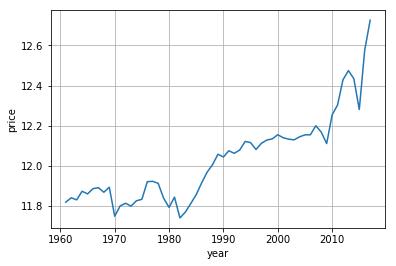

In [67]:
%matplotlib inline
temp = dr.groupby('year_built').agg({'logSaleAmount':'mean'})
plt.plot(temp);plt.xlabel("year");plt.ylabel("price");plt.grid(True)

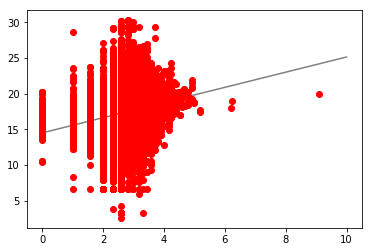

In [117]:
olsmodel = sm.OLS.from_formula("dr.logSaleAmount ~ dr.logrooms", data=dr)
result = olsmodel.fit()
params = result.params.values
xr = np.linspace(0,10, 20)
plt.plot(xr, params[0] + params[1]*xr, '-', color='grey')
plt.plot(dr.logrooms,dr.logSaleAmount,'ro')

(array([  1.77000000e+02,   1.72000000e+03,   2.46835000e+05,
          7.97850000e+04,   1.34500000e+03,   2.40000000e+01,
          2.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          1.00000000e+00]),
 array([ 0.        ,  0.90848084,  1.81696168,  2.72544252,  3.63392336,
         4.54240419,  5.45088503,  6.35936587,  7.26784671,  8.17632755,
         9.08480839]),
 <a list of 10 Patch objects>)

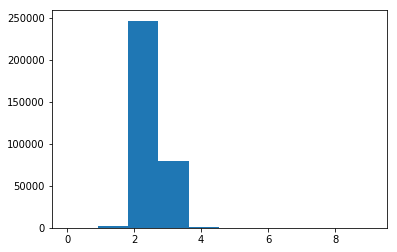

In [112]:
dr.logrooms = np.log2(dr.total_rooms)
plt.hist(dr.logrooms)

# survival

In [6]:
import pandas as pd
import numpy as np

dpath = "deed0010.gz"

dtp = {"SALE DATE (YYYYMMDD)": str}

rdr = pd.read_csv(dpath, delimiter="|", chunksize=200000, low_memory=False, 
                  dtype=dtp)

# Loop over sub-chunks
dat = []
while True:

    try:
        df = rdr.get_chunk()
    except StopIteration:
        break

    df["SALE DATE (YYYYMMDD)"] =\
           pd.to_datetime(df["SALE DATE (YYYYMMDD)"], format="%Y%m%d", errors='coerce')

    dx = df[["APN (Parcel Number) (unformatted)", "SALE DATE (YYYYMMDD)", "SALE AMOUNT", "MORTGAGE AMOUNT",
             "RESALE/NEW CONSTRUCTION", "RESIDENTIAL MODEL INDICATOR", "CASH/MORTGAGE PURCHASE",
             "FORECLOSURE", "FIPS", "TRANSACTION TYPE"]]
    ii = pd.notnull(dx[["APN (Parcel Number) (unformatted)", "SALE DATE (YYYYMMDD)", "CASH/MORTGAGE PURCHASE",
                        "TRANSACTION TYPE"]]).all(1)
    dx = dx.loc[ii, :]

    # Only retain records that are for "arms length sales"
    dx = dx.loc[dx["TRANSACTION TYPE"] == 1, :]

    # Convert to a number (days since 1960-01-01)
    dx["SALE DATE"] = dx["SALE DATE (YYYYMMDD)"] - pd.to_datetime("1960-01-01")
    dx["SALE DATE"] = dx["SALE DATE"].dt.days
    dx["SALE DATE"] = dx["SALE DATE"].astype(np.float64)

    # Drop non-residential properties
    dx = dx.loc[dx["RESIDENTIAL MODEL INDICATOR"] == "Y"]

    # Drop properties with only one record
    gb = dx.groupby("APN (Parcel Number) (unformatted)")
    nr = pd.DataFrame(gb.size())
    nr.columns = ["numrecs"]
    dx = pd.merge(dx, nr, left_on="APN (Parcel Number) (unformatted)", right_index=True)
    dx = dx.loc[dx.numrecs > 1]
    
    dx = dx.loc[:, ["APN (Parcel Number) (unformatted)", "SALE DATE", "SALE AMOUNT", "FIPS", 
                    "CASH/MORTGAGE PURCHASE", "MORTGAGE AMOUNT"]]

    dat.append(dx)

deed = pd.concat(dat, axis=0)


In [7]:
deed.head()

,APN (Parcel Number) (unformatted),SALE DATE,SALE AMOUNT,FIPS,CASH/MORTGAGE PURCHASE,MORTGAGE AMOUNT
68,&A388500002,19039.0,257300.0,55127,Q,NaN
69,&A388500002,19058.0,257300.0,55127,Q,NaN
75,&LA1 00010,19530.0,265000.0,55127,Q,NaN
76,&LA1 00010,20011.0,265000.0,55127,Q,NaN
78,&LA1 00010,20709.0,321400.0,55127,Q,NaN


In [8]:
dpath = "tax0010.gz"

dtp = {"CENSUS TRACT": str} #"SALE DATE (YYYYMMDD)": str}

rdr = pd.read_csv(dpath, delimiter="|", chunksize=200000, low_memory=False, 
                  dtype=dtp, error_bad_lines=False)

n = 0
# Loop over sub-chunks
dat = []
while True:

    try:
        df = rdr.get_chunk()
    except StopIteration:
        break
    
    n += df.shape[0]

    # Keep only single family residences
    df = df.loc[df["PROPERTY INDICATOR"] == 10, :]

    dx = df[['FIPS CODE', 'UNFORMATTED APN', 'YEAR BUILT', \
             'BUILDING SQUARE FEET', 'LIVING SQUARE FEET', 'TOTAL ROOMS', \
             'CONDITION', \
             'CONSTRUCTION TYPE','EXTERIOR WALLS','FLOOR','FRAME','PARKING SPACES','STORIES CODE','POOL','QUALITY']]
    ii = pd.notnull(dx[["UNFORMATTED APN"]]).all(1)
    dx = dx.loc[ii, :]
    
    dat.append(dx)

tax = pd.concat(dat, axis=0)

# Keep only one record per house
tax = tax.groupby("UNFORMATTED APN").head(1)

# We need to know the year in which the house was built
tax = tax.loc[pd.notnull(tax["YEAR BUILT"]), :]

Skipping line 66407: expected 179 fields, saw 180
Skipping line 139634: expected 179 fields, saw 180
Skipping line 179350: expected 179 fields, saw 181
Skipping line 183451: expected 179 fields, saw 180

Skipping line 201002: expected 179 fields, saw 181
Skipping line 220708: expected 179 fields, saw 180

Skipping line 472089: expected 179 fields, saw 180
Skipping line 534273: expected 179 fields, saw 181

Skipping line 769660: expected 179 fields, saw 180
Skipping line 770426: expected 179 fields, saw 180
Skipping line 770468: expected 179 fields, saw 180
Skipping line 770692: expected 179 fields, saw 180
Skipping line 796714: expected 179 fields, saw 180

Skipping line 821943: expected 179 fields, saw 180
Skipping line 840992: expected 179 fields, saw 180
Skipping line 841199: expected 179 fields, saw 180
Skipping line 851094: expected 179 fields, saw 180
Skipping line 866985: expected 179 fields, saw 180
Skipping line 890553: expected 179 fields, saw 180
Skipping line 895255: expect

In [29]:
data_new = pd.merge(deed_n,tax,on='UNFORMATTED APN')
data_new.to_csv("data_new2.csv", compression="gzip")
data_new.columns = ['apn','SaleDate','SaleAmount','FIPS', 'resale','popu','FIPS2','year_built','building_feet','living_feet' ,'total_rooms','condition','construction','wall','floor','frame','parking','stories','pool','quality']
data_new = data_new[['apn','SaleDate','SaleAmount','FIPS','popu','year_built','living_feet' ,'total_rooms','condition','construction','pool','quality']]

In [30]:
data_new = data_new[['apn','SaleDate','SaleAmount','FIPS','popu','year_built','living_feet' ,'total_rooms','condition','construction','quality']]
data_new['logSaleAmount'] = np.log2(data_new.SaleAmount)
data_new['logpop'] = np.log2(data_new.popu)
dr = data_new
dr = dr.loc[pd.notnull(dr.SaleAmount)]
dr = dr.loc[pd.notnull(dr.year_built)]
dr = dr.loc[pd.notnull(dr.living_feet)]
dr = dr.loc[pd.notnull(dr.condition)]
dr = dr.loc[pd.notnull(dr.quality)]
dr = dr.loc[pd.notnull(dr.construction)]
dr = dr.loc[dr.construction != '001']
dr = dr.loc[dr.SaleAmount>1]
dr['logliving_feet'] = np.log2(dr.living_feet)
dr['SaleYear'] = (dr.SaleDate/365 + 1960).astype(int)
dr = dr.loc[dr.SaleYear>1959]
dr.SaleDate = dr.SaleDate - 6936
dr['condition2'] = dr.condition.replace(['AVE', 'GOO', 'POO', 'VGO', 'EXC', 'FAI', 'UNS', 'DMG', 'UCN', 'GTE','001'],
                                     [0,1,-3,2,4,-1,-3,-2,0,3,0])
dr['quality2'] = dr.quality.replace(['QAV', 'QGO', 'QFA', 'QVV', '001','QEX','QBA','QLO','QPO','QEC','QLU','000'],
                                     [0,2,-3,1,0,3,-2,-4,-5,-1,4,0])
dr['condition'] = dr.condition.replace(['AVE', 'GOO', 'POO', 'VGO', 'EXC', 'FAI', 'UNS', 'DMG', 'UCN', 'GTE','001'],
                                     ['AVE', 'GOO', 'POO', 'VGO', 'EXC', 'FAI', 'UNS', 'DMG', 'AVE', 'GTE','AVE'])
dr['quality'] = dr.quality.replace(['QAV', 'QGO', 'QFA', 'QVV', '001','QEX','QBA','QLO','QPO','QEC','QLU','000'],
                                     ['QAV', 'QGO', 'QFA', 'QVV', 'QAV','QEX','QBA','QLO','QPO','QEC','QLU','AVE'])
dr['age'] = dr.SaleYear - dr.year_built
dr.SaleDate = dr.SaleDate-364
dr.logSaleAmount = (np.log2(dr.SaleAmount))
dr.shape

(42982, 18)

In [82]:
deed_n.iloc[:,0].value_counts()

17 01060028001        160
122    00300 000       87
601390019              70
494126270060           68
R1426157               45
116273640              41
206100                 41
071    01600 000       40
1604201001053000       40
R1344931               39
074    01800 000       39
111    00500 000       36
29W130625              35
C11000001102500        34
17 00990012045         34
6705320040050907       33
1141900090011          33
29X330143              33
070    01100 000       33
22343020030000         32
1205700413             31
331626330325000029     31
21163407               31
011    00600 000       31
21163509               31
5734010108             30
1205700290             30
070    02900 000       30
015    04800 000       30
066    01700 000       29
                     ... 
291501016003000020      1
001172332               1
C0040370061             1
2949030050130901        1
170902567120000         1
R75692                  1
2F2314063010            1
004355267   

In [13]:
dr.head()

,apn,SaleDate,SaleAmount,FIPS,popu,year_built,living_feet,total_rooms,condition,construction,quality,logSaleAmount,logpop,logliving_feet,SaleYear,condition2,quality2,age
14543,0005226,12943.0,28000.00,37081,512119.0,1965.0,1279.0,5.0,AVE,MAS,QAV,14.773139,18.966120,10.320801,2015,0,0,50.0
14544,0005226,13263.0,75000.00,40083,45276.0,1965.0,1279.0,5.0,AVE,MAS,QAV,16.194603,15.466459,10.320801,2016,0,0,51.0
14547,0005226,12496.0,91732.24,48077,10370.0,1965.0,1279.0,5.0,AVE,MAS,QAV,16.485141,13.340128,10.320801,2014,0,0,49.0
14563,0006980,9062.0,95000.00,37081,512119.0,1941.0,1257.0,7.0,AVE,FRM,QGO,16.535640,18.966120,10.295769,2004,0,2,63.0
14564,0006980,9127.0,105000.00,37081,512119.0,1941.0,1257.0,7.0,AVE,FRM,QGO,16.680030,18.966120,10.295769,2005,0,2,64.0


In [115]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib
matplotlib.use('Agg')
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.pyplot as plt

In [124]:
dx = dx.copy()
dx = dx.sort_values(by=['apn', 'SaleDate'], ascending=[True, True])
dx["apn"] = dx["apn"].astype("category").cat.codes
dx = dx.sort_values(by=['apn', 'SaleDate'], ascending=[True, True])
dx['tdiff'] = dx.SaleDate.diff().shift(-1)
m = dx.apn != dx.apn.shift(-1)
y = (pd.to_datetime("2017-07-01") - pd.to_datetime("1960-01-01")).days
dx['tdiff'][m] = y - dx['SaleDate'][m]
dx["status"] = 1
dx["status"][m] = 0
gb=dx.groupby('apn')
nr = pd.DataFrame(gb.size())
nr.columns = ["numrecs"]
dx = pd.merge(dx, nr, left_on="apn", right_index=True)
dx = dx.loc[dx.numrecs > 1]
dx = dx.copy()
dx["apn"] = dx["apn"].astype("category").cat.codes

In [265]:
nam=[]
for i in range(1970,2010):
    nam.append('pop'+str(i))
for i in fu:
    temp = popu.loc[popu.f == i].loc[popu.FIPS !=i]
    for j in cc:
        popu.loc[(popu.f == i) & (popu.FIPS ==i),j]=temp[j].get_values()
dx.popu2=dx.popu

In [502]:
for i in range(dx.shape[0]):
    temp = popu.loc[popu.FIPS == dx.FIPS.iloc[i]]
    year = dx.SaleYear.iloc[i]
    if year<2015:
        year = 'pop'+ str(year)
        dx['popu2'].iloc[i] = temp[year].get_values()

In [511]:
dx.head(10)

,apn,SaleDate,SaleAmount,FIPS,popu,year_built,living_feet,total_rooms,condition,construction,...,SaleYear,condition2,quality2,age,tdiff,status,numrecs_x,numrecs_y,popu2,mindate
38291,0,7993.0,143000.0,12057,1316298.0,1988.0,2168.0,NaN,AVE,FRY,...,2001,0,1,13.0,1283.0,1,2,2,1026319.0,7993.0
38292,0,9276.0,282000.0,12057,1316298.0,1988.0,2168.0,NaN,AVE,FRY,...,2005,0,1,17.0,11725.0,0,2,2,1132025.0,7993.0
52829,1,5646.0,39000.0,42003,1231255.0,1905.0,2001.0,5.0,GOO,LOG,...,1995,1,0,90.0,2249.0,1,5,5,1304958.0,5646.0
52830,1,7895.0,74100.0,42003,1231255.0,1905.0,2001.0,5.0,GOO,LOG,...,2001,1,0,96.0,2329.0,1,5,5,1272519.0,5646.0
52831,1,10224.0,164000.0,42003,1231255.0,1905.0,2001.0,5.0,GOO,LOG,...,2008,1,0,103.0,219.0,1,5,5,1218227.0,5646.0
52832,1,10443.0,175000.0,42003,1231255.0,1905.0,2001.0,5.0,GOO,LOG,...,2008,1,0,103.0,2893.0,1,5,5,1218227.0,5646.0
52833,1,13336.0,249000.0,42003,1231255.0,1905.0,2001.0,5.0,GOO,LOG,...,2016,1,0,111.0,7665.0,0,5,5,1231255.0,5646.0
16774,2,9458.0,160000.0,37037,68698.0,1979.0,1412.0,NaN,GOO,BRK,...,2005,1,0,26.0,3174.0,1,3,3,57849.0,9458.0
16775,2,12632.0,152000.0,37037,68698.0,1979.0,1412.0,NaN,GOO,BRK,...,2014,1,0,35.0,347.0,1,3,3,68698.0,9458.0
16772,2,12979.0,109000.0,40031,125033.0,1979.0,1412.0,NaN,GOO,BRK,...,2015,1,0,36.0,8022.0,0,3,3,125033.0,9458.0


In [508]:
dx["mindate"] = dx.groupby("apn")["SaleDate"].transform(np.min)

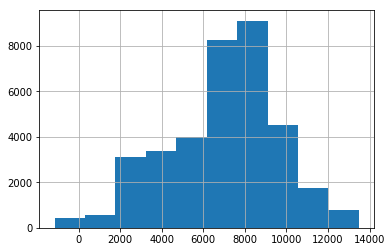

In [510]:
%matplotlib inline
dx.mindate.hist()

In [512]:
dy = dx.loc[dx.tdiff > 0, :] # need to get to the bottom of this
dy.tdiff /= 365.25

/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/pandas/core/generic.py:3110: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


In [526]:
sf = sm.duration.SurvfuncRight(dy.tdiff, dy.status)


In [529]:
from scipy.interpolate import interp1d

spr, spt = [], []
for k,g in dy.groupby("FIPS"):
    if g.shape[0] < 20:
        continue
    s0 = sm.duration.SurvfuncRight(g.tdiff, g.status)
    if s0.surv_times.min() < 10 and s0.surv_times.max() > 10:
        f = interp1d(s0.surv_times, s0.surv_prob)
        if s0.surv_times.min() <=1 and s0.surv_times.max() >= 15:
            spt.append([f(t) for t in range(1, 15)])
        g = interp1d(s0.surv_times, s0.surv_prob_se)
        se = float(g(10))
        if np.isfinite(se):
            spr.append([float(f(10)), float(g(10))])
spr = np.asarray(spr)
spt = np.asarray(spt)

/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/statsmodels/duration/survfunc.py:55: RuntimeWarning: divide by zero encountered in log
  sp = np.log(sp)
/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/statsmodels/duration/survfunc.py:65: RuntimeWarning: divide by zero encountered in divide
  se = d / (n * (n - d)).astype(np.float64)
/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/statsmodels/duration/survfunc.py:68: RuntimeWarning: invalid value encountered in multiply
  se *= sp


In [556]:
# Use PCA on the FIPS-level survival functions to identify the
# dominant patterns of variation.
spq = np.log(spt / (1 - spt))
spq -= spq.mean(0)
cc = np.cov(spq.T)
spc, s, vt = np.linalg.svd(cc, 0)

In [548]:
# Proportional hazards regression looking at effects of calendar time
# and time from previous sale.
model = sm.PHReg.from_formula("tdiff ~ bs(SaleYear, 6)", status="status", data=dy)
result = model.fit()
bhaz = result.baseline_cumulative_hazard

pdf = PdfPages("turnover.pdf")

plt.clf()
plt.plot(sf.surv_times, sf.surv_prob, '-', rasterized=True)
plt.xlabel("Years", size=15)
plt.ylabel("Probability not sold", size=15)
plt.title("U.S. marginal survival function for home retention")
pdf.savefig()

plt.clf()
plt.title("10 year retention rate by FIPS")
plt.hist(spr[:,0])
plt.xlabel("Rate", size=15)
plt.ylabel("Frequency", size=15)
pdf.savefig()

plt.clf()
y = np.arange(1, 15)
plt.title("Transformed survivor functions by FIPS region")
for i in range(spq.shape[0]):
    plt.plot(y, spq[i, :], color='grey', alpha=0.5)
plt.xlabel("Years since purchase", size=15)
plt.ylabel("Logit probability not sold (centered)", size=15)
pdf.savefig()

plt.clf()
plt.title("PC's of FIPS-level survival functions")
plt.plot(spc[:,0])
plt.plot(spc[:,1])
plt.xlabel("Time", size=15)
plt.ylabel("Loading", size=15)
pdf.savefig()

# Plot top and bottom scoring curves for the top 2 PC's
sc = np.dot(spq, spc[:, 0:2])
for k in 0,1:
    ii = np.argsort(sc[:, k])
    plt.clf()
    for i in ii[0:20]:
        plt.plot(y, spt[i, :], color='blue', alpha=0.5)
    for i in ii[-20:]:
        plt.plot(y, spt[i, :], color='red', alpha=0.5)
    plt.xlabel("Years since purchase", size=15)
    plt.ylabel("Probability not sold", size=15)
    plt.title("Top/bottom 20 for PC %d" % (k + 1))
    pdf.savefig()

plt.clf()
y = np.asarray(dy.SaleYear)[0::50]
z = result.predict().predicted_values[0::50]
ii = np.argsort(y)
plt.ylabel("Log hazard ratio", size=15)
plt.xlabel("Year", size=15)
plt.plot(y[ii], z[ii], '-', rasterized=True)
pdf.savefig()


ValueError: A value in x_new is above the interpolation range.

In [550]:

from scipy.misc import derivative

plt.clf()
f = interp1d(bhaz[0][0], bhaz[0][1])
xh = np.linspace(1, 40, 40)
ha = [derivative(f, x, dx=0.5) for x in xh]
plt.plot(xh, ha, '-')
plt.xlabel("Years since purchase", size=15)
plt.ylabel("Hazard", size=15)
pdf.savefig()

pdf.close()

In [557]:
result.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                             Results: PHReg
=========================================================================
Model:                       PH Reg           Sample size:          35411
Dependent variable:          tdiff            Num. events:          24333
Ties:                        Breslow                                     
-------------------------------------------------------------------------
                    log HR log HR SE   HR      t     P>|t|  [0.025 0.975]
-------------------------------------------------------------------------
bs(SaleYear, 6)[0] -1.0695    0.2157 0.3432  -4.9577 0.0000 0.2248 0.5238
bs(SaleYear, 6)[1] -0.2273    0.1203 0.7966  -1.8901 0.0587 0.6293 1.0084
bs(SaleYear, 6)[2] -0.4932    0.1423 0.6107  -3.4653 0.0005 0.4620 0.8072
bs(SaleYear, 6)[3] -0.9211    0.1342 0.3981  -6.8645 0.0000 0.3060 0.5178
bs(SaleYear, 6)[4] -1.5518    0.1531 0.2119 -10.1361 0.0000 0.1569 0.2860
bs(SaleYear, 6)[5] -3.4988    0.1619 0.0302 -21.6070 0.0000 0.0220 0.0415
=========================================================================
Confidence intervals are for the hazard ratios
"""